In [3]:
%load_ext autoreload
%autoreload 2
import torch

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import glob
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from distributions import QuantizedNormal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
seed=360
# tracts/distributions
S=23

# total timepoints
T= 500
K=3

low_set_1_10 = [QuantizedNormal(10, 0.3) for _ in range(10)]
low_set_2_10 = [QuantizedNormal(30, 0.3) for _ in range(10)]
high_set_3 = [QuantizedNormal(50,3) for _ in range(3)]

dist_S = low_set_1_10 + low_set_2_10 + high_set_3

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

In [8]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/synth_103050_4000_comp2'
exps = glob.glob(base_dir + '/*')
model = MixtureOfTruncNormModel(num_components=2, S=23)

In [19]:
def make_report(model, exp, data, title=None):
    model.load_state_dict(torch.load(exp + '/model.pth'))
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])

    
    # Make an html page with plots of loss, bpr, nll
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].plot(losses)
    ax[0, 0].set_title('Loss')
    ax[0, 1].plot(bprs)
    ax[0, 1].set_title('BPR')
    ax[1, 0].plot(nlls)
    ax[1, 0].set_title('NLL')
    model.plot_learned(data=train_y_TS, ax=ax[1, 1])
    fig.savefig(exp + '/report.png')
    

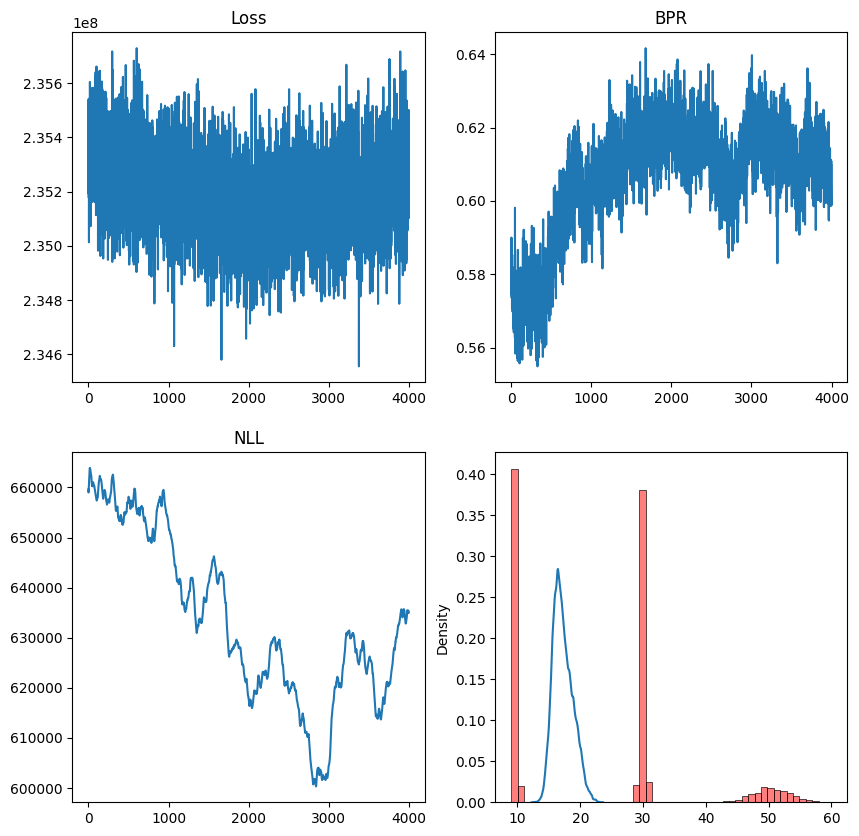

In [20]:
make_report(model, exps[0], train_y_TS)

In [14]:
 exps[0]

'/cluster/tufts/hugheslab/kheuto01/synth_103050_4000_comp2/bw1000000_nw0_sig0.01_ss0.001_th0.95'